In [1]:
import numpy as np
import instrument as ins
import isochrones as iso
import galaxy as gal
import driver
import matplotlib.pyplot as plt
import matplotlib as mpl
import fit_model

pycuda not installed.
GPU acceleration not available, sorry


In [2]:
import time

In [3]:
import utils
import gpu_utils
# from scipy.stats import poisson
import time
import emcee
# import corner
%matplotlib inline

In [4]:
reload(gpu_utils)

pycuda not installed.
GPU acceleration not available, sorry


<module 'gpu_utils' from 'gpu_utils.pyc'>

In [60]:
reload(driver)

<module 'driver' from 'driver.py'>

In [5]:
def plot_pixcmd(colors, mags, ax=None, colorbar=True):
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.hist2d(colors, mags, bins=150, cmap='viridis', norm=mpl.colors.LogNorm())
    if colorbar:
        plt.colorbar(label='Pixel Counts')
    return ax

In [6]:
im_scale = 256
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]
n_filters = len(filters)

In [7]:
iso_model = iso.Isochrone_Model(filters)
# gal_model_complex = gal.Galaxy_Model(1e2, np.array([6.5, 7.5, 8.25, 8.75, 9.25, 9.75, 10.1]), np.array([0.,1.,1.,1.,1.,1.,1.]), 0., 0.)
gal_model_simple = gal.Galaxy_SSP(np.array([0., -2., 1., 10.]))
gal_model_dust = gal.Galaxy_SSP(np.array([0., -0.5, 1., 10.]))
gal_model_full = gal.Galaxy_Model(np.array([0., -2., 1., 1., 1., 1., 1., 1., 1.]))

In [8]:
driver_cpu = driver.Driver(iso_model, gpu=False)
# driver_gpu = driver.Driver(iso_model, gpu=True)

In [8]:
SFH_SSP, mags_SSP = iso_model.model_galaxy(gal_model_simple)
SFH_full, mags_full = iso_model.model_galaxy(gal_model_full)

In [9]:
fluxes_SSP = np.array([f.mag_to_counts(m) for f,m in zip(filters, mags_SSP)])
fluxes_full = np.array([f.mag_to_counts(m) for f,m in zip(filters, mags_full)])

In [10]:
def time_func(func, SFH, fluxes, N_scale_arr):
    time_arr = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        start = time.time()
        _ = func(SFH, fluxes, N_scale_arr[i])
        time_arr[i] = time.time() - start
    return time_arr

In [28]:
N_scale_arr = np.array([128, 256, 512, 1024, 2048, 4096])

In [29]:
times_cudac_SSP = time_func(gpu_utils._draw_image_cudac, SFH_SSP, fluxes_SSP, N_scale_arr)
# times_pycuda_SSP = time_func(gpu_utils._draw_image_pycuda, SFH_SSP, fluxes_SSP, N_scale_arr)
# times_numpy_SSP = time_func(gpu_utils._draw_image_numpy, SFH_SSP, fluxes_SSP, N_scale_arr[:-1])

In [30]:
times_cudac_full = time_func(gpu_utils._draw_image_cudac, SFH_full, fluxes_full, N_scale_arr)
# times_pycuda_full = time_func(gpu_utils._draw_image_pycuda, SFH_full, fluxes_full, N_scale_arr)
# times_numpy_full = time_func(gpu_utils._draw_image_numpy, SFH_full, fluxes_full, N_scale_arr[:-2])

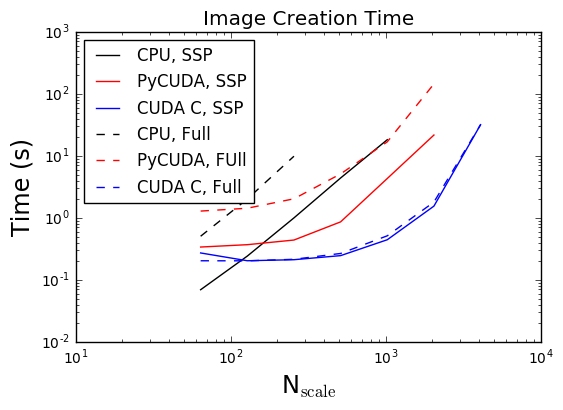

In [34]:
fig, axis =plt.subplots()
axis.plot(N_scale_arr[:-2], times_numpy_SSP, ls='-', color='k', label='CPU, SSP')
axis.plot(N_scale_arr[:-1], times_pycuda_SSP, ls='-', color='r', label='PyCUDA, SSP')
axis.plot(N_scale_arr, times_cudac_SSP, ls='-', color='b', label='CUDA C, SSP')
axis.plot(N_scale_arr[:-4], times_numpy_full, ls='--', color='k', label='CPU, Full')
axis.plot(N_scale_arr[:-1], times_pycuda_full, ls='--', color='r', label='PyCUDA, FUll')
axis.plot(N_scale_arr, times_cudac_full, ls='--', color='b', label='CUDA C, Full')
axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large'), axis.set_ylabel('Time (s)', fontsize='xx-large')
axis.legend(loc=2), axis.set_yscale('log'), axis.set_xscale('log')
axis.set_title('Image Creation Time', fontsize='x-large')
plt.savefig('results/image_draw_time.pdf')

In [11]:
%%time
_, mags_sim, _, _ = driver_gpu.simulate(gal_model_simple, 1024, psf=True)

CPU times: user 1.07 s, sys: 294 ms, total: 1.36 s
Wall time: 1.65 s


In [12]:
pcmd = utils.make_pcmd(mags_sim)

In [13]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 5.6, 0.05)
bins = np.array([xbins, ybins])

In [14]:
driver_cpu.initialize_data(pcmd, bins)
driver_gpu.initialize_data(pcmd, bins)

In [9]:
def time_simulate(driv, model, N_scale_arr):
    time_arr = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        start = time.time()
        _ = driv.simulate(model, N_scale_arr[i])
        time_arr[i] = time.time() - start
    return time_arr

In [ ]:
%%time
_ = driver_cpu.simulate(gal_model_full, 512)

CPU times: user 40.3 s, sys: 11.7 s, total: 52 s
Wall time: 1min 5s


In [26]:
driver_cpu.filters[0]

<instrument.Filter instance at 0x10867e368>

In [75]:
time_simulate(driver_cpu, gal_model_simple, np.array([128, 256, 512, 1024]))

array([  0.36985397,   1.30005002,   5.06553221,  19.27793097])

In [76]:
time_simulate(driver_gpu, gal_model_simple, np.array([128, 256, 512, 1024]))

array([ 0.40248585,  0.44264197,  0.70423079,  1.63383412])

In [27]:
gal_model_simple.__class__

<class galaxy.Galaxy_SSP at 0x2b6fc1ea5598>

In [28]:
def time_loglike(driv, model, N_scale_arr):
    time_arr = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        start = time.time()
        _ = fit_model.lnprob(model._params, driv, N_scale_arr[i], gal_class=model.__class__)
        time_arr[i] = time.time() - start
    return time_arr

In [45]:
cpu_time_loglike_SSP = time_loglike(driver_cpu, gal_model_simple, np.array([128, 256, 512, 1024]))
# gpu_time_loglike_SSP = time_loglike(driver_gpu, gal_model_simple, np.array([128, 256, 512, 1024, 2048]))

In [43]:
# cpu_time_loglike_full = time_loglike(driver_cpu, gal_model_full, np.array([128, 256, 512]))
gpu_time_loglike_full = time_loglike(driver_gpu, gal_model_full, np.array([128, 256, 512, 1024, 2048]))

ValueError: x and y must have same first dimension

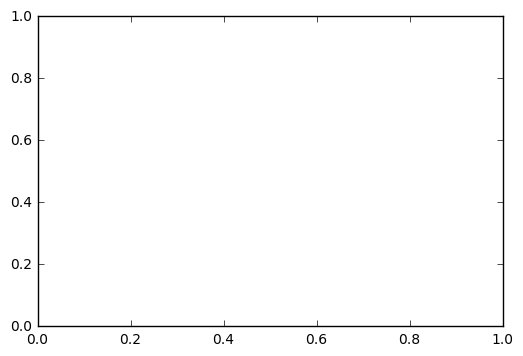

In [46]:
fig, axis =plt.subplots()
N_arr = np.array([128, 256, 512, 1024, 2048])
axis.plot(N_arr[:-2], cpu_time_loglike_SSP, ls='-', color='k', label='CPU, SSP')
axis.plot(N_arr, gpu_time_loglike_SSP, ls='-', color='b', label='CUDA C, SSP')
axis.plot(N_arr[:-2], cpu_time_loglike_full, ls='--', color='k', label='CPU, Full')
axis.plot(N_arr, gpu_time_loglike_full, ls='--', color='b', label='CUDA C, Full')
axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large'), axis.set_ylabel('Time (s)', fontsize='xx-large')
axis.legend(loc=0), axis.set_yscale('log'), axis.set_xscale('log')
axis.set_title('Likelihood Call Time', fontsize='x-large')
plt.savefig('results/likelihood_call_time.pdf')

In [49]:
def time_psf(driv, gal_model, N_scale_arr, multi_psf=True, iters=5):
    f = driv.filters[0]
    times = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        N_scale = N_scale_arr[i]
#         _, _, images, _ = driv.simulate(gal_model, N_scale, psf=False)
#         im = images[0]
        im = np.random.uniform(low=0, high=1e5, size=(N_scale, N_scale))
        temp = []
        for j in np.arange(iters):
            start = time.time()
            _ = f.psf_convolve(im, multi_psf=multi_psf)
            temp.append(time.time() - start)
        times[i] = np.mean(temp)
    return times

In [53]:
N_scale_arr = np.array([256, 512, 1024, 2048, 4096])
times = time_psf(driver_cpu, gal_model_simple, N_scale_arr)
times_simple = time_psf(driver_cpu, gal_model_simple, N_scale_arr, multi_psf=False)

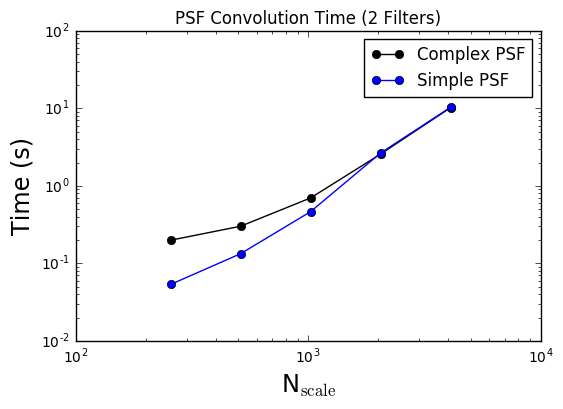

In [55]:
fig, axis = plt.subplots()
axis.plot(N_scale_arr, 2.*times, 'ko-', label='Complex PSF')
axis.plot(N_scale_arr, 2.*times_simple, 'bo-', label='Simple PSF')
axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large'), axis.set_ylabel(r'Time (s)', fontsize='xx-large')
plt.legend(loc=0)
axis.set_xscale('log'), axis.set_yscale('log')
axis.set_title('PSF Convolution Time (2 Filters)')
plt.savefig('results/PSF_convolve_time.pdf')

In [21]:
%%time
_=gpu_utils._draw_image_numpy(SFH, fluxes, 256)

CPU times: user 9.44 s, sys: 808 ms, total: 10.2 s
Wall time: 10.2 s


In [22]:
%%time
_=gpu_utils._draw_image_pycuda(SFH, fluxes, 256)

CPU times: user 1.15 s, sys: 704 ms, total: 1.86 s
Wall time: 2.05 s


In [23]:
%%time
_=gpu_utils._draw_image_cudac(SFH, fluxes, 256)

CPU times: user 72 ms, sys: 26 ms, total: 98 ms
Wall time: 224 ms


In [ ]:
import pycuda.curandom

In [36]:
%%time
_, mags_sim, _, _ = driver_gpu.simulate(gal_model_simple, 1024, psf=False)

CPU times: user 402 ms, sys: 84 ms, total: 486 ms
Wall time: 709 ms


In [20]:
%%time
_, mags_dust, _, _ = driver_gpu.simulate(gal_model_dust, im_scale)

CPU times: user 1.16 s, sys: 184 ms, total: 1.35 s
Wall time: 1.47 s


In [82]:
%%time
_, mags_data, _, _ = driver_gpu.simulate(gal_model_simple, im_scale)

CPU times: user 4.18 s, sys: 305 ms, total: 4.48 s
Wall time: 4.6 s


In [7]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_simple, 1024)

CPU times: user 2.97 s, sys: 1.98 s, total: 4.95 s
Wall time: 5.3 s


In [48]:
# pcmd_sim = np.array([mags_sim[0]-mags_sim[1], mags_sim[1]])
pcmd_data = np.array([mags_data[0]-mags_data[1], mags_data[1]])
# pcmd_dust = np.array([mags_dust[0]-mags_dust[1], mags_dust[1]])

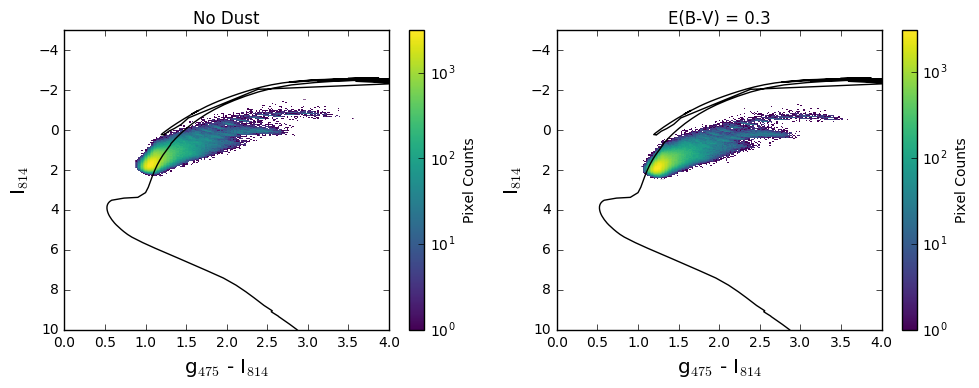

In [236]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(pcmd_sim[0], pcmd_sim[1], ax=axes[0], colorbar=True)
plot_pixcmd(pcmd_dust[0], pcmd_dust[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_simple, ax=axes[0])
iso_model.plot_isochrone(gal_model_simple, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([0, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([0, 4])
axes[0].set_title('No Dust'), axes[1].set_title('E(B-V) = 0.3')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [21]:
pcmd_data = driver_gpu._make_pcmd(mags_sim)
pcmd_dust = driver_gpu._make_pcmd(mags_dust)

In [113]:
reload(driver)
driver_cpu = driver.Driver(iso_model, gpu=False)

GPU acceleration not available


In [23]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 5.6, 0.05)
bins = [xbins, ybins]

driver_gpu.initialize_data(pcmd_data, bins)

In [24]:
driver_gpu.loglike(pcmd_dust, use_gaussian=True, charlie=False)

-355129.09018144867

In [25]:
driver_gpu.loglike(pcmd_dust, use_gaussian=True, charlie=True)

-354906.74314799561

In [26]:
driver_gpu.initialize_data(pcmd_data, bins)

In [9]:
def lnprior(gal_params):
    log_Npix, age, z, dust = gal_params
    #Flat prior
    #Npix between 0.1 and 1e6
    if (log_Npix < -1) or (log_Npix > 6):
        return -np.inf
    #age between 6 (1 Myr) and 10.3 (50 Gyr)
    elif (age < 6.) or (age > 10.3):
        return -np.inf
    #z between -2 and 0.5
    elif (z < -2.) or (z>0.5):
        return -np.inf
    #E(B-V) between 0 and 2
    elif (dust < -0.5) or (dust > 2.):
        return -np.inf
    else:
        return 1

In [10]:
def lnprob(gal_params, driv, im_scale, **kwargs):
    pri = lnprior(gal_params)
    if np.isinf(pri):
        return -np.inf
    gal_model = gal.Simple_Galaxy(gal_params)
    _, mags, _, _ = driv.simulate(gal_model, im_scale)
    pcmd = np.array([mags[0]-mags[1], mags[1]])
    return pri + driv.loglike(pcmd, **kwargs)

In [27]:
nwalkers = 10
ndim = 4
# Npix0 = (5*np.random.random(size=nwalkers)) #log-uniform from 1e0 -> 1e5
# age0 = 6.+(4.*np.random.random(size=nwalkers)) #uniform from 6 -> 10
# z0 = -1.5 + (2.*np.random.random(size=nwalkers)) #uniform from -1.5 -> 0.5
# dust_0 = np.random.random(size=nwalkers) #uniform from 0 -> 1
# p0 = np.array([Npix0, age0, z0, dust_0]).T

In [28]:
p0_single = np.array([2.1, 10., -0.1, 0.2])

In [29]:
p0 = emcee.utils.sample_ball(p0_single, np.array([.5, 0.1, 0.25, 0.1]),
                             size=nwalkers)

In [30]:
p0

array([[  2.65788809,   9.9509787 ,  -0.44473897,   0.1593951 ],
       [  2.35831675,   9.88118485,  -0.26360956,   0.13124404],
       [  2.12662815,  10.03458054,  -0.0450831 ,   0.256572  ],
       [  1.60030576,   9.95491743,  -0.20052581,   0.07332498],
       [  2.60411377,   9.96278638,  -0.18755041,   0.31408711],
       [  2.09429014,   9.86597811,   0.0684526 ,   0.35543917],
       [  2.45808529,   9.99215514,  -0.15567886,   0.31870128],
       [  2.3058259 ,  10.09414496,  -0.02139286,   0.1291896 ],
       [  2.60033984,  10.01661933,  -0.14780299,   0.30935007],
       [  3.13715033,   9.85811219,  -0.37741214,   0.18540717]])

In [31]:
p0.shape

(10, 4)

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[driver_gpu, 512]) #test with 256x256 models

In [33]:
%%time
sampler.reset()
pos, prob, state = sampler.run_mcmc(p0, 20)

CPU times: user 3min 46s, sys: 35.2 s, total: 4min 21s
Wall time: 4min 46s


In [37]:
%%time
sampler.reset()
sampler.run_mcmc(pos, 80)

CPU times: user 13min 21s, sys: 2min 31s, total: 15min 52s
Wall time: 17min 30s


In [34]:
sampler.lnprobability

array([[-522593.91748426, -522593.91748426, -522593.91748426,
        -518711.80301518, -518711.80301518, -518711.80301518,
        -480591.77836348, -475628.03713136, -475628.03713136,
        -475628.03713136, -475628.03713136, -475628.03713136,
        -475628.03713136, -475628.03713136, -475628.03713136,
        -475628.03713136, -475628.03713136, -475628.03713136,
        -428112.33885728, -425370.33961375],
       [-498283.02879135, -473634.72360562, -437850.39134557,
        -437850.39134557, -437850.39134557, -436587.90511794,
        -372465.67765645, -372465.67765645, -372070.61319091,
        -372070.61319091, -372070.61319091, -372070.61319091,
        -372070.61319091, -372070.61319091, -372070.61319091,
        -372070.61319091, -372070.61319091, -353115.75176593,
        -291896.95698825, -151241.14465791],
       [-491441.29811646, -458383.78081027, -452747.27782479,
        -452747.27782479, -452747.27782479, -452747.27782479,
        -452747.27782479, -452747.27782479

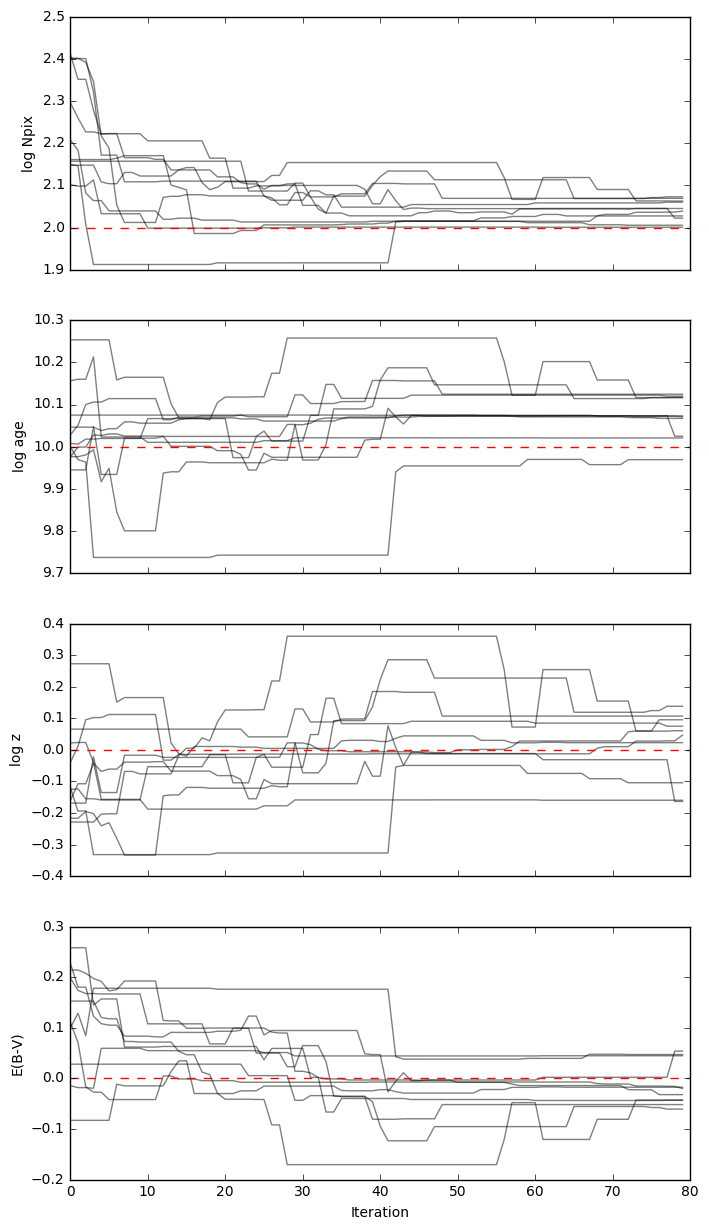

In [38]:
fig, axes = plt.subplots(figsize=(8,15), nrows=4, sharex=True)
for i in np.arange(4):
    vals = sampler.chain[:,:,i]
    for arr in vals:
        axes[i].plot(arr, ls='-', alpha=0.5, c='k')
axes[3].set_xlabel('Iteration')
axes[0].set_ylabel('log Npix')
axes[0].axhline(y=2, ls='--', color='r')
axes[1].set_ylabel('log age')
axes[1].axhline(y=10., ls='--', color='r')
axes[2].set_ylabel('log z')
axes[2].axhline(y=0., ls='--', color='r')
axes[3].set_ylabel('E(B-V)')
axes[3].axhline(y=0., ls='--', color='r')

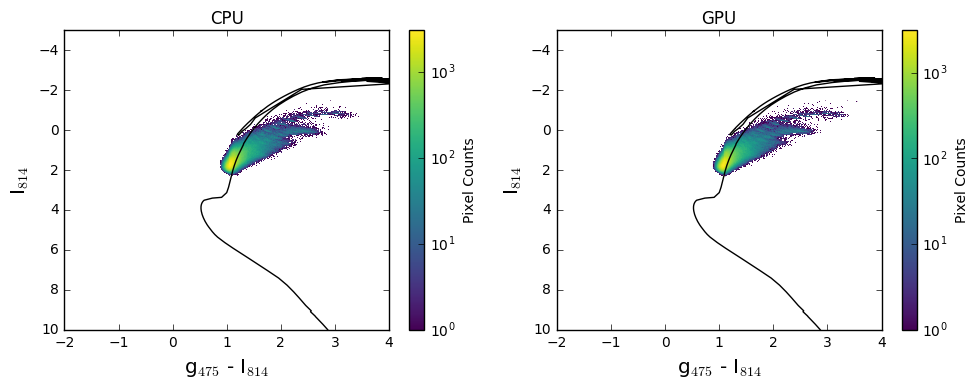

In [8]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(mags_c[0]-mags_c[1], mags_c[1], ax=axes[0], colorbar=True)
plot_pixcmd(mags_g[0]-mags_g[1], mags_g[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_simple, ax=axes[0])
iso_model.plot_isochrone(gal_model_simple, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([-2, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([-2, 4])
axes[0].set_title('CPU'), axes[1].set_title('GPU')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [9]:
%%time
raw_mags_c, mags_c, raw_images_c, images_c = driver_cpu.simulate(gal_model_complex, 512)

CPU times: user 19.4 s, sys: 3.49 s, total: 22.9 s
Wall time: 28 s


In [10]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_complex, 512)

CPU times: user 3.67 s, sys: 845 ms, total: 4.52 s
Wall time: 5.98 s


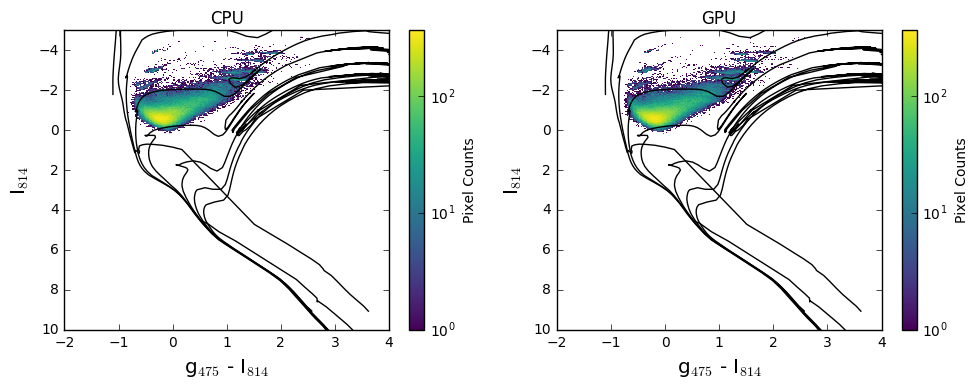

In [11]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(mags_c[0]-mags_c[1], mags_c[1], ax=axes[0], colorbar=True)
plot_pixcmd(mags_g[0]-mags_g[1], mags_g[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_complex, ax=axes[0])
iso_model.plot_isochrone(gal_model_complex, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([-2, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([-2, 4])
axes[0].set_title('CPU'), axes[1].set_title('GPU')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [21]:
scale_arr = [128, 256, 512, 1024, 2048, 4096]

t_cpu_simple = np.zeros_like(scale_arr, dtype=float)
t_gpu_simple = np.zeros_like(scale_arr, dtype=float)
t_cpu_complex = np.zeros_like(scale_arr, dtype=float)
t_gpu_complex = np.zeros_like(scale_arr, dtype=float)

In [ ]:
for i, scale in enumerate(scale_arr):
    print('Evaluating %d pixels'%(scale))
    if (scale < 2048):
        print('---CPU Simple')
        start = time.time()
        _ = driver_cpu.simulate(gal_model_simple, scale)
        t_cpu_simple[i] = time.time() - start
    if (scale < 1024):
        print('---CPU Complex')
        start = time.time()
        _ = driver_cpu.simulate(gal_model_complex, scale)
        t_cpu_complex[i] = time.time() - start
    print('---GPU Simple')
    start = time.time()
    _ = driver_gpu.simulate(gal_model_simple, scale)
    t_gpu_simple[i] = time.time() - start
    print('---GPU Complex')
    start = time.time()
    _ = driver_gpu.simulate(gal_model_complex, scale)
    t_gpu_complex[i] = time.time() - start

Evaluating 128 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 256 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 512 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 1024 pixels
---CPU Simple
---GPU Simple
---GPU Complex
Evaluating 2048 pixels
---GPU Simple
---GPU Complex
Evaluating 4096 pixels
---GPU Simple
---GPU Complex


In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(scale_arr[:-1], t_cpu_simple[:-1], 'ro', ls='-', label='CPU, SSP')
ax.plot(scale_arr[:-2], t_cpu_complex[:-2], 'r*', ls='--', label='CPU, Complex')
ax.plot(scale_arr, t_gpu_simple, 'bo', ls='-', label='GPU, SSP')
ax.plot(scale_arr, t_gpu_complex, 'b*', ls='--', label='GPU, Complex')
ax.legend(loc=4)
ax.set_xlabel('Image Scale (NxN pixels)', fontsize='xx-large')
# ax.set_xscale('log')
ax.set_xticks(scale_arr)
ax.set_ylabel('Time Elapsed (s)', fontsize='xx-large')
ax.set_yscale('log')